# ETL & EDA

## Librerías Utilizadas

In [21]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport

import warnings 
warnings.filterwarnings("ignore")

import gc

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import FuncFormatter
import seaborn as sns

sns.set_theme(palette="muted")

from sklearn.linear_model import LinearRegression

---
- Carga de datos

In [22]:
# Aggregated Taxi
df = pd.read_csv(r'..\..\datasets\1. Originales\TLC Aggregated Data\data_reports_monthly.csv')
df.head()

,Month/Year,License Class,Trips Per Day,Farebox Per Day,Unique Drivers,Unique Vehicles,Vehicles Per Day,Avg Days Vehicles on Road,Avg Hours Per Day Per Vehicle,Avg Days Drivers on Road,Avg Hours Per Day Per Driver,Avg Minutes Per Trip,Percent of Trips Paid with Credit Card,Trips Per Day Shared
0,2024-08,FHV - Black Car,"20,022",-,"9,648","9,729","3,732",11.9,4.3,12.0,4.3,27.0,-,-
1,2024-08,FHV - High Volume,"617,043",-,"81,306","80,570","55,030",21.2,6.3,21.3,6.3,19.0,-,"10,185"
2,2024-08,FHV - Livery,"26,995",-,"8,816","8,709","4,650",16.6,4.5,16.6,4.4,21.0,-,-
3,2024-08,FHV - Lux Limo,808,-,"1,378","1,345",449,10.4,1.8,10.4,1.7,68.0,-,-
4,2024-08,Green,"1,654","38,632",728,694,394,17.6,3.5,17.0,3.4,14.9,72%,-


In [23]:
df.columns

Index(['Month/Year', 'License Class', 'Trips Per Day', 'Farebox Per Day',
       'Unique Drivers', 'Unique Vehicles', 'Vehicles Per Day',
       'Avg Days Vehicles on Road', 'Avg Hours Per Day Per Vehicle',
       'Avg Days Drivers on Road', 'Avg Hours Per Day Per Driver',
       'Avg Minutes Per Trip', 'Percent of Trips Paid with Credit Card',
       'Trips Per Day Shared'],
      dtype='object')

- Se renombran las columnas

In [24]:
df.columns = [
    'month_year', 'industry', 'trips_per_day', 'farebox_per_day',
    'unique_drivers', 'unique_vehicles', 'vehicles_per_day',
    'avg_days_vehicles_on_road', 'avg_hours_per_day_per_vehicle',
    'avg_days_drivers_on_road', 'avg_hours_per_day_per_driver',
    'avg_minutes_per_trip', 'percent_of_trips_paid_with_credit_card',
    'trips_per_day_shared'
]

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 773 entries, 0 to 772
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   month_year                              773 non-null    object 
 1   industry                                773 non-null    object 
 2   trips_per_day                           773 non-null    object 
 3   farebox_per_day                         773 non-null    object 
 4   unique_drivers                          773 non-null    object 
 5   unique_vehicles                         773 non-null    object 
 6   vehicles_per_day                        773 non-null    object 
 7   avg_days_vehicles_on_road               773 non-null    float64
 8   avg_hours_per_day_per_vehicle           773 non-null    float64
 9   avg_days_drivers_on_road                773 non-null    float64
 10  avg_hours_per_day_per_driver            773 non-null    float6

- Se obervan 773 valores no nulos.
- La separación de miles está dada por una ",", se reemplaza este valor en todas las columnas
- Se observa que los nulos en el dataset se completan con '-'. Se cuenta la cantidad de veces que aprece en cada campo. Tener en cuenta que en **`month_year`** aparece porque es la separación de la fecha y en **`license_class`** porque es parte del nombre.

In [26]:
df.applymap(lambda x: str(x).count('-')).sum()

month_year                                773
industry                                  464
trips_per_day                               0
farebox_per_day                           464
unique_drivers                              0
unique_vehicles                             0
vehicles_per_day                            0
avg_days_vehicles_on_road                   0
avg_hours_per_day_per_vehicle               0
avg_days_drivers_on_road                    0
avg_hours_per_day_per_driver                0
avg_minutes_per_trip                        0
percent_of_trips_paid_with_credit_card    464
trips_per_day_shared                      670
dtype: int64

In [27]:
df.applymap(lambda x: str(x).count(',')).sum()

month_year                                  0
industry                                    0
trips_per_day                             750
farebox_per_day                           473
unique_drivers                            719
unique_vehicles                           717
vehicles_per_day                          653
avg_days_vehicles_on_road                   0
avg_hours_per_day_per_vehicle               0
avg_days_drivers_on_road                    0
avg_hours_per_day_per_driver                0
avg_minutes_per_trip                        0
percent_of_trips_paid_with_credit_card      0
trips_per_day_shared                       58
dtype: int64

- Se reemplazan los valores en todas las columnas menos las indicadas.

In [28]:
# Columnas incuidas
columns_to_replace = df.columns.difference(['month_year', 'industry'])
# Reemplazar '-' por '' en las columnas seleccionadas
df[columns_to_replace] = df[columns_to_replace].replace({'-':np.nan,',':'','%': ''}, regex=True)

- Se corrigen los tipos de datos

In [29]:
df['month_year'] = pd.to_datetime(df['month_year'] + '-01')
df['industry'] = df['industry'].astype('category')
df['trips_per_day'] = df['trips_per_day'].astype('Int64')
df['farebox_per_day'] = df['farebox_per_day'].astype('Int64')
df['unique_drivers'] = df['unique_drivers'].astype('Int64')
df['unique_vehicles'] = df['unique_vehicles'].astype('Int64')
df['vehicles_per_day'] = df['vehicles_per_day'].astype('Int64')
df['percent_of_trips_paid_with_credit_card'] = pd.to_numeric(df['percent_of_trips_paid_with_credit_card'], errors='coerce') / 100
df['trips_per_day_shared'] = pd.to_numeric(df['trips_per_day_shared'], errors='coerce') 

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 773 entries, 0 to 772
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   month_year                              773 non-null    datetime64[ns]
 1   industry                                773 non-null    category      
 2   trips_per_day                           773 non-null    Int64         
 3   farebox_per_day                         309 non-null    Int64         
 4   unique_drivers                          773 non-null    Int64         
 5   unique_vehicles                         773 non-null    Int64         
 6   vehicles_per_day                        773 non-null    Int64         
 7   avg_days_vehicles_on_road               773 non-null    float64       
 8   avg_hours_per_day_per_vehicle           773 non-null    float64       
 9   avg_days_drivers_on_road                773 non-null  

In [31]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
month_year,773,2019-02-06 03:15:36.093143808,2010-01-01 00:00:00,2016-08-01 00:00:00,2019-04-01 00:00:00,2021-12-01 00:00:00,2024-08-01 00:00:00,NaN
trips_per_day,773.0,153012.769728,148.0,11359.0,29858.0,282565.0,769729.0,209865.031838
farebox_per_day,309.0,2504076.194175,4028.0,331003.0,1903868.0,4869413.0,6744373.0,2353988.037155
unique_drivers,773.0,17931.340233,129.0,3626.0,7361.0,27655.0,87779.0,22679.45493
unique_vehicles,773.0,14887.945666,114.0,3442.0,6909.0,13319.0,86540.0,21703.924077
vehicles_per_day,773.0,10337.02458,33.0,1956.0,3988.0,12089.0,60900.0,14800.700942
avg_days_vehicles_on_road,773.0,19.765589,6.7,15.4,19.6,23.7,30.1,5.452133
avg_hours_per_day_per_vehicle,773.0,6.230401,1.8,3.6,5.4,6.8,15.3,3.596255
avg_days_drivers_on_road,773.0,18.139974,6.8,15.3,19.1,21.3,23.2,3.663444
avg_hours_per_day_per_driver,773.0,5.225485,1.7,3.6,5.3,6.5,8.5,1.930351


In [32]:
numeric_columns = [
    'trips_per_day', 'farebox_per_day', 'unique_drivers', 'unique_vehicles', 
    'vehicles_per_day', 'avg_days_vehicles_on_road', 'avg_hours_per_day_per_vehicle',
    'avg_days_drivers_on_road', 'avg_hours_per_day_per_driver', 'avg_minutes_per_trip',
    'percent_of_trips_paid_with_credit_card', 'trips_per_day_shared'
]

In [33]:
df['month_year'].dt.year.unique()

array([2024, 2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014,
       2013, 2012, 2011, 2010], dtype=int32)

---
## Gráfico 1: Histograma y boxplot de variables numéricas
- No hay presencia de outliers

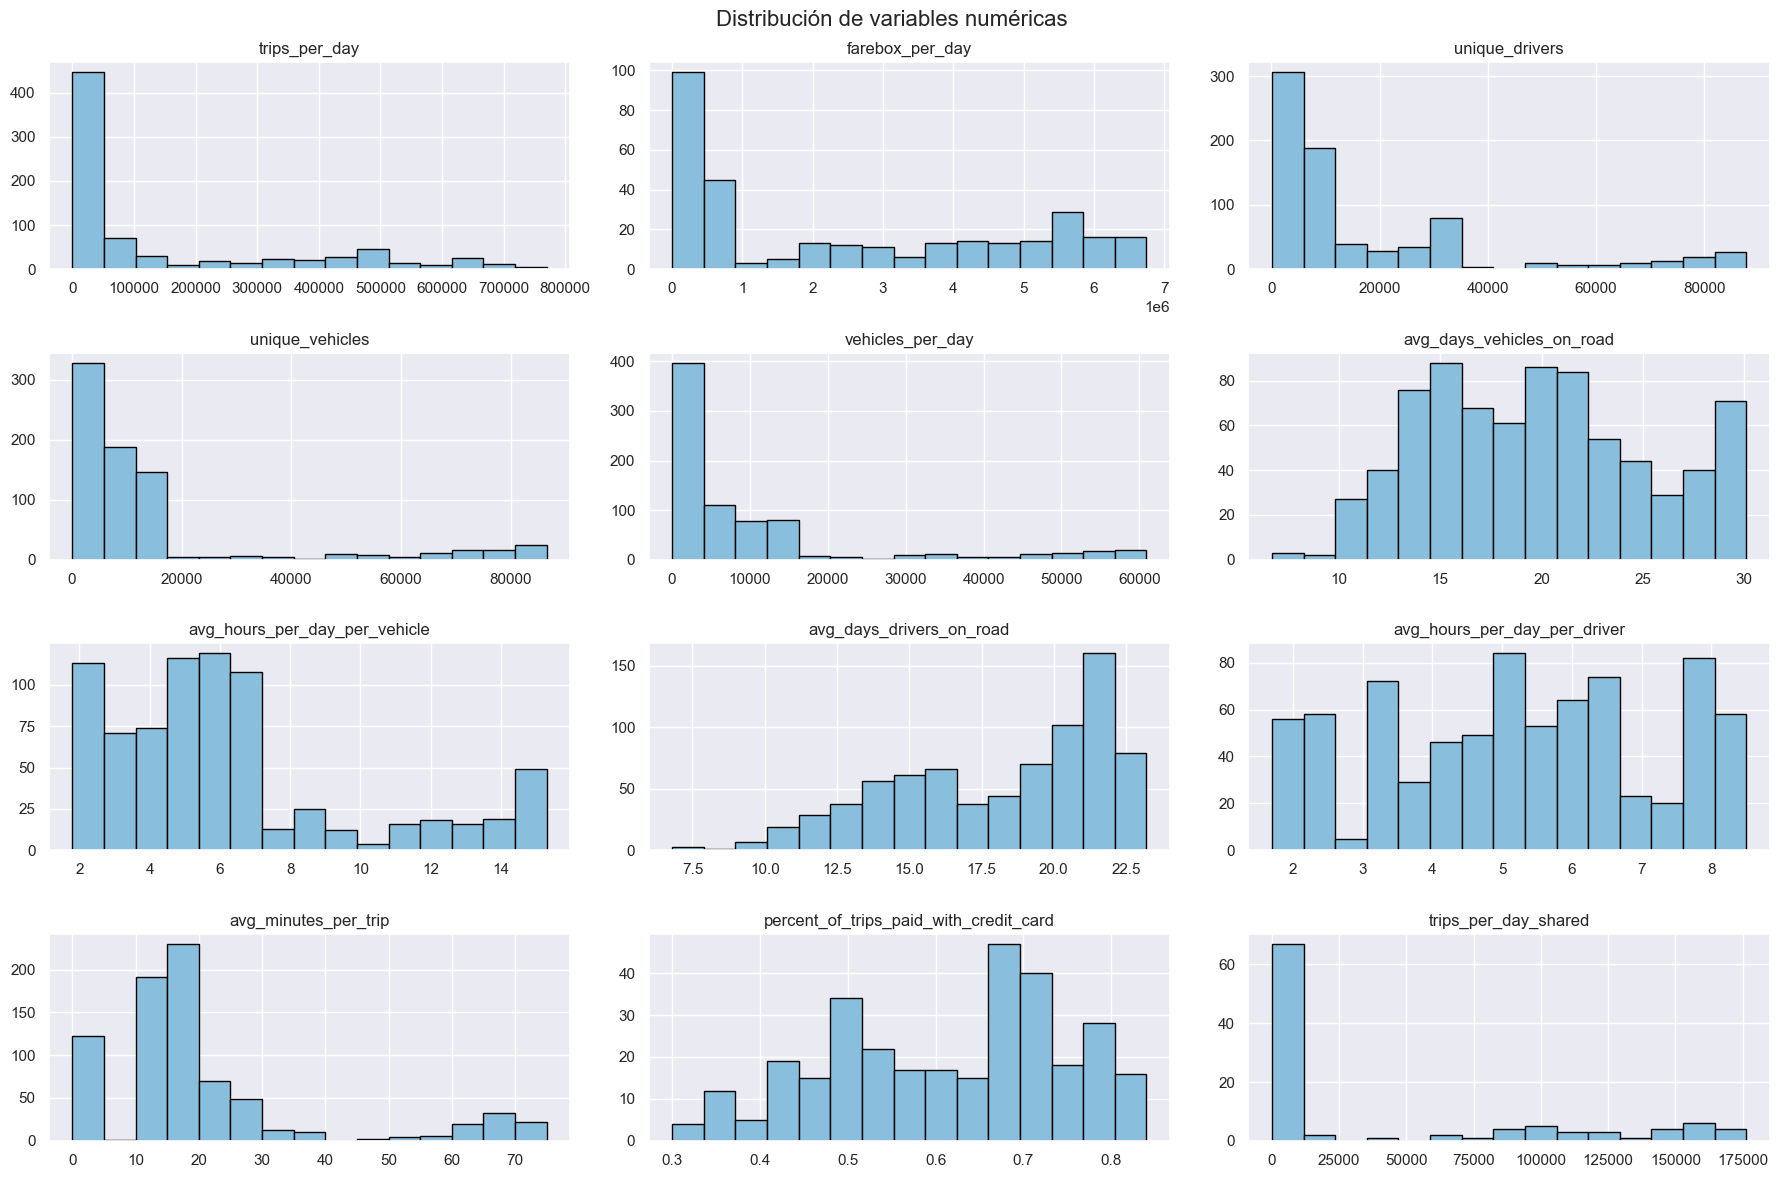

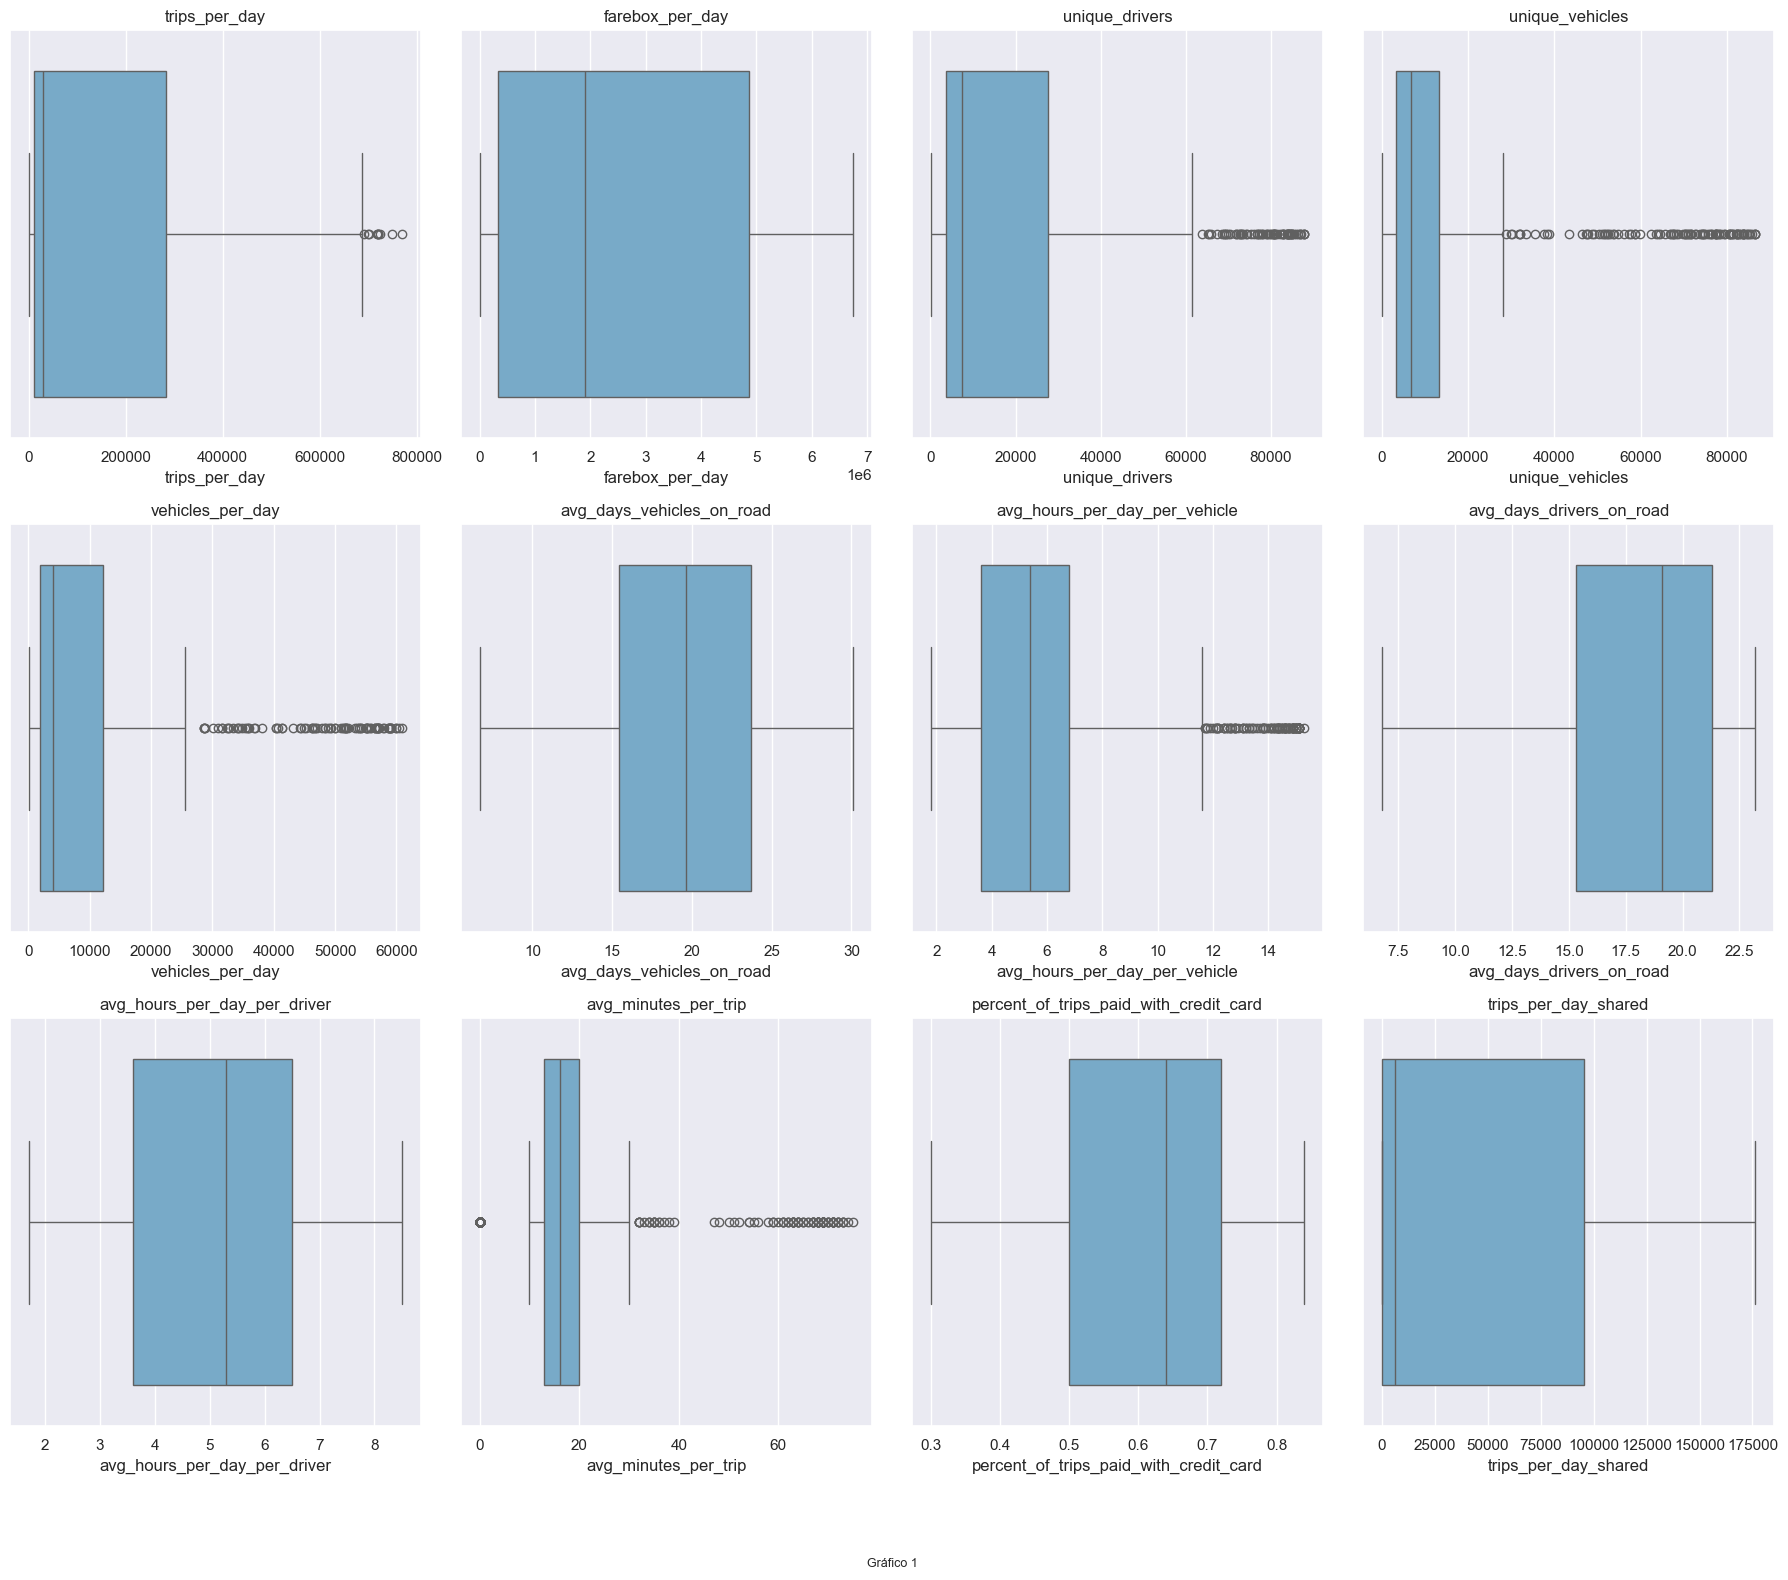

In [34]:
# Histograma de cada variable numérica con 'Blues' para Matplotlib
# Calcular el número de filas 
num_rows = (len(numeric_columns) + 2) // 3  # Redondear hacia arriba al dividir entre 3

fig, axes = plt.subplots(num_rows, 3, figsize=(18, 12))
axes = axes.flatten()  # Convertir el arreglo 2D en 1D

# Graficar cada histograma
for i, column in enumerate(numeric_columns):
    axes[i].hist(df[column].dropna(), bins=15, color=sns.color_palette('Blues')[2], edgecolor='black')
    axes[i].set_title(column, fontsize=12)

plt.suptitle("Distribución de variables numéricas", fontsize=16)
plt.tight_layout()
plt.show()

# Boxplots de las variables numéricas con 'Blues' para Seaborn
plt.figure(figsize=(18, 15))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(3, 4, i)  # Usar cuadrícula 3x4
    sns.boxplot(data=df, x=column, palette="Blues")
    plt.title(column, fontsize=12)
plt.figtext(0.5, -0.05, "Gráfico 1", wrap=True, horizontalalignment='center', fontsize=9)
plt.tight_layout()
plt.show()


## Gráfico 2: Análisis de correlación
- Alto grado de correlación entre: **`trips_per_day`**, **`farebox_per_day`**, **`unique_drivers`**, **`unique_vehicles`**, **`vehicles_per_day`**
- Alto grado de correlación entre los promedios diarios de las mismas variables.

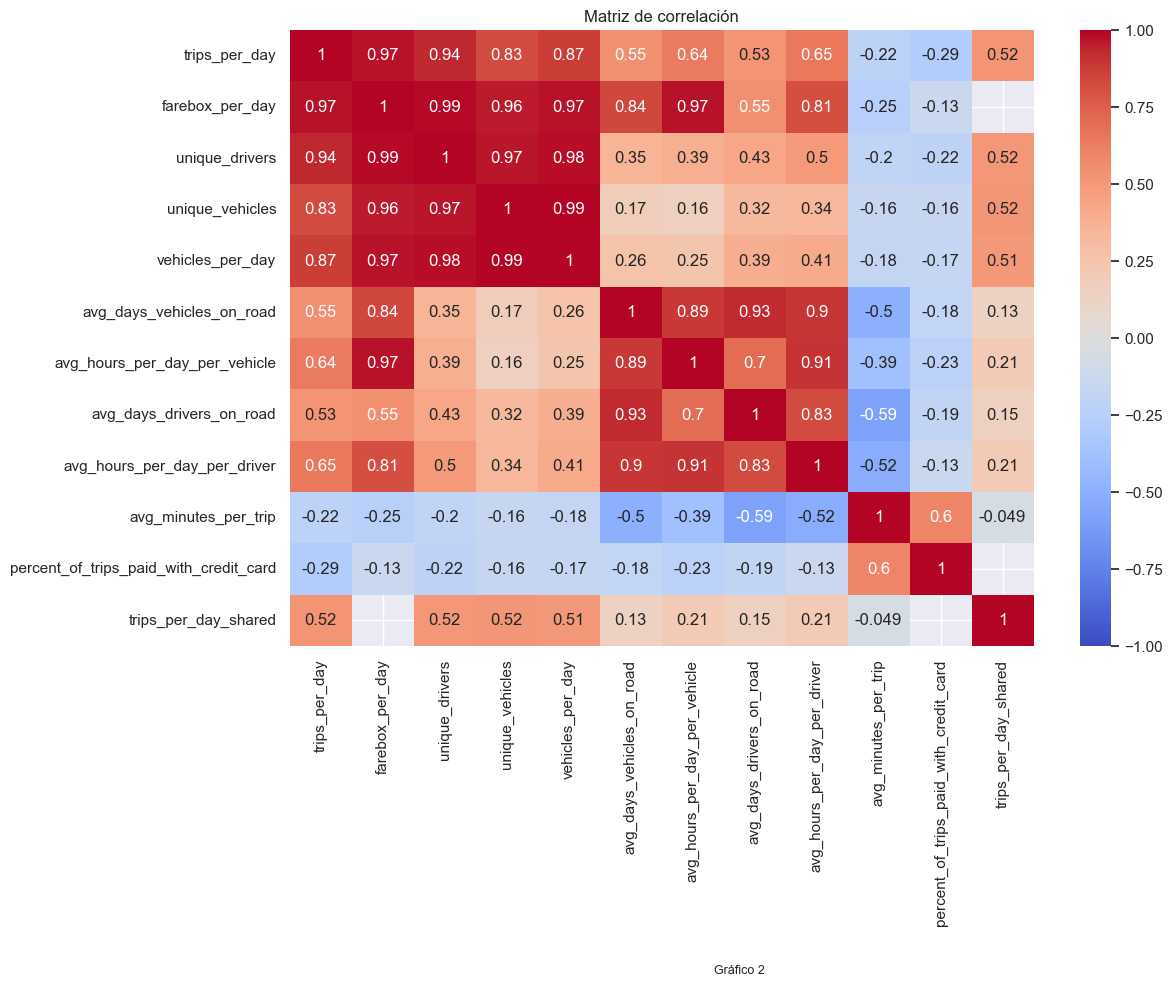

In [35]:
# Matriz de correlación
correlation_matrix = df[numeric_columns].corr()

# Mapa de calor de la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.figtext(0.5, -0.3, "Gráfico 2", wrap=True, horizontalalignment='center', fontsize=9)
plt.title("Matriz de correlación")
plt.show()

# Análisis de tiempo
## Gráfico 3: Evolución Temporal de Cantidad de Viajes por Día, Facturación por Día, Cantidad de Conductores por Día y Cantidad de Vehículos por Industria

- Se observa el fenómeno de la pandemia durante el año 2020.
- Se puede ver como la cantidad de viajes, conductores y vehículos de la categoría FHV - High Volume es la que empieza a liderar el mercado desde que hay datos en el año 2015.
- No hay información de la facturación de la industria FHV.

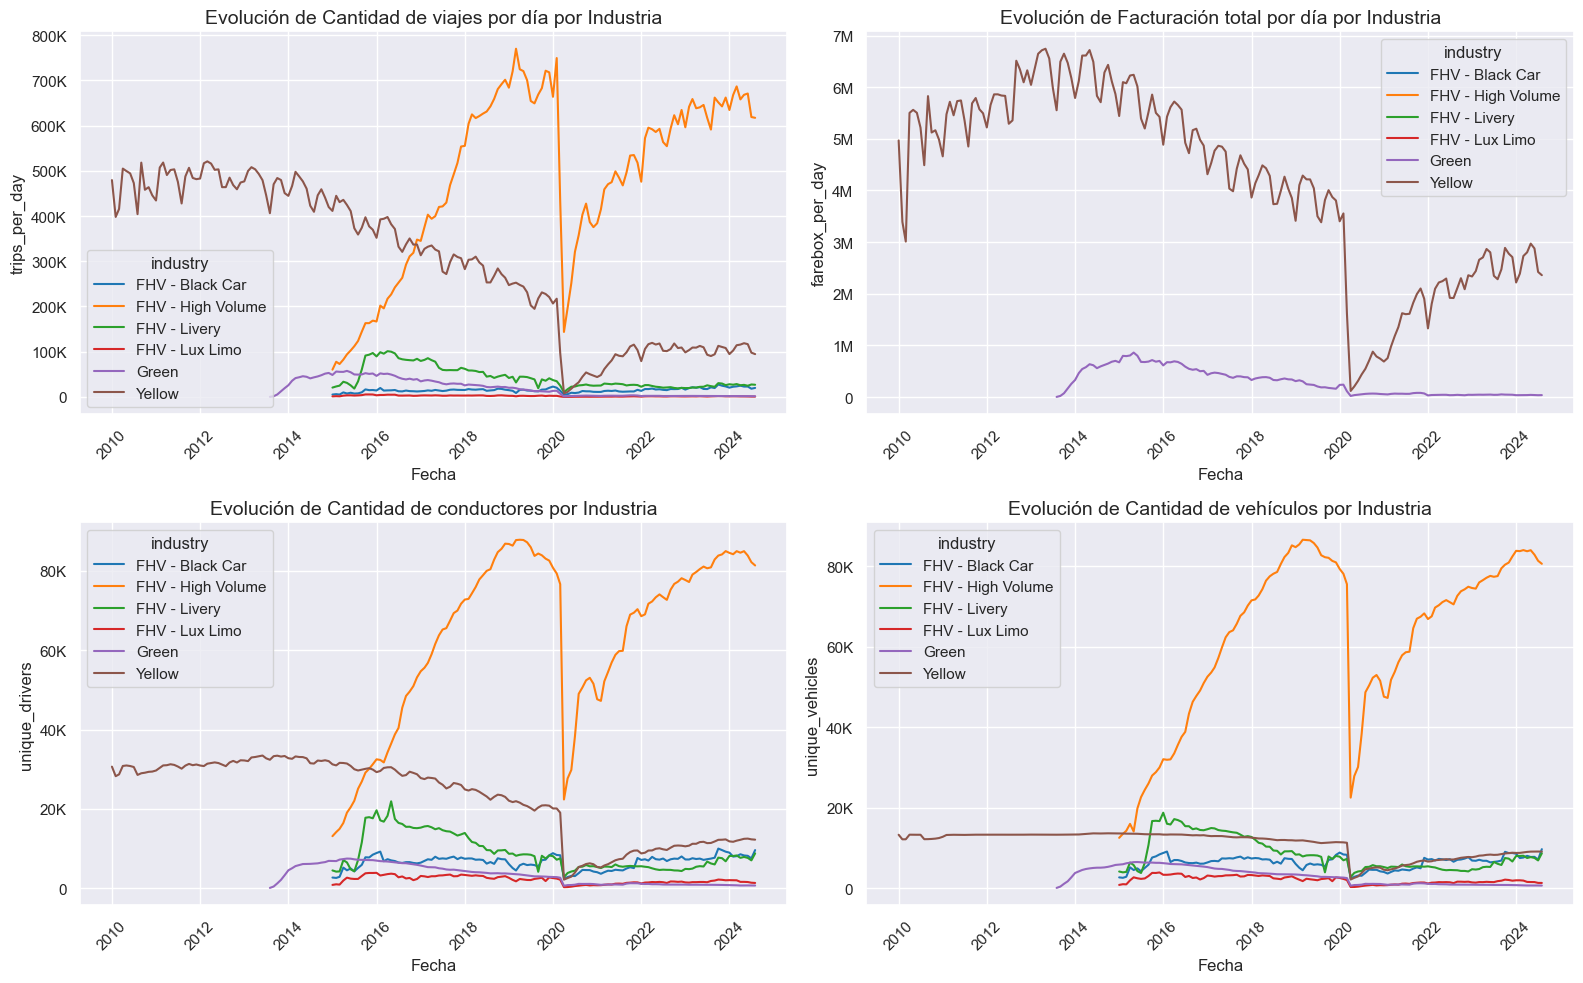

In [ ]:
# Gráficos de series temporales para analizar la evolución en el tiempo, separados por 'industry'
time_columns = ['trips_per_day', 'farebox_per_day', 'unique_drivers', 'unique_vehicles']

columns = {
    'trips_per_day': 'Cantidad de viajes por día',
    'farebox_per_day': 'Facturación total por día',
    'unique_drivers': 'Cantidad de conductores',
    'unique_vehicles': 'Cantidad de vehículos'
}

def format_axis_y(value, tick_position):
    if value >= 1_000_000:
        return f'{value//1_000_000:.0f}M'
    elif value >= 1_000:
        return f'{value//1_000:.0f}K'
    else:
        return str(int(value)) 
    

plt.figure(figsize=(16, 10))
for i, column in enumerate(time_columns, 1):
    plt.subplot(2, 2, i)
    sns.lineplot(data=df, x='month_year', y=column, hue='industry', palette="tab10")
    plt.title(f"Evolución de {columns[column]} por Industria", fontsize=14)
    plt.xlabel('Fecha')
    plt.xticks(rotation=45)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_axis_y))

# Crear la leyenda en un solo cuadro fuera de los gráficos
plt.figtext(0.5, -0.05, "Gráfico 3", wrap=True, horizontalalignment='center', fontsize=9)
plt.tight_layout()
plt.show()


## Gráfico 4: Evolución de porcentaje de pagos con tarjta de crédito
- Se observa el crecimiento constante de la cantidad de pagos realizados con tarjeta de crédito.

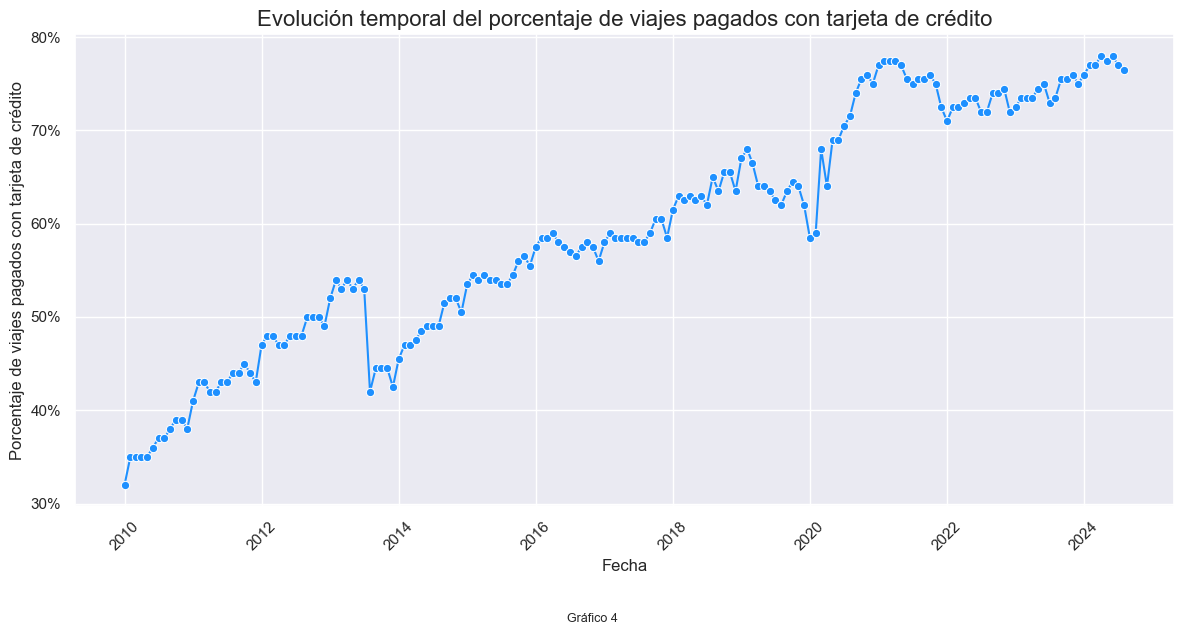

In [37]:
df['month_year'] = pd.to_datetime(df['month_year'], format='%Y-%m')

# Gráfico de la evolución temporal del porcentaje de viajes pagados con tarjeta de crédito
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='month_year', y='percent_of_trips_paid_with_credit_card', marker='o', color='dodgerblue', ci=None)
plt.title("Evolución temporal del porcentaje de viajes pagados con tarjeta de crédito", fontsize=16)
plt.xlabel("Fecha")
plt.ylabel("Porcentaje de viajes pagados con tarjeta de crédito")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.figtext(0.5, -0.05, "Gráfico 4", wrap=True, horizontalalignment='center', fontsize=9)
plt.tight_layout()
plt.show()

## Gráfico 5: Evolución de cantidad de viajes compartidos
- Se observa que a partir de la pandemia hubo una gran reducción y aún no se ha recuperado.

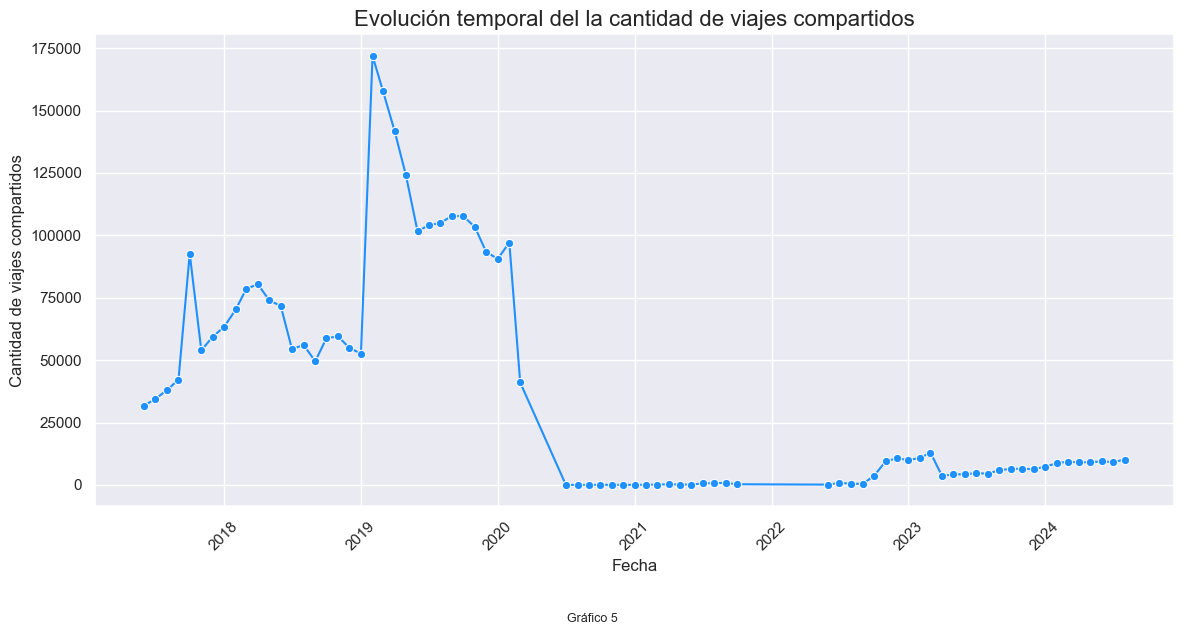

In [38]:
# Gráfico de la evolución temporal del porcentaje de viajes pagados con tarjeta de crédito
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='month_year', y='trips_per_day_shared', marker='o', color='dodgerblue', ci=None)
plt.title("Evolución temporal del la cantidad de viajes compartidos", fontsize=16)
plt.xlabel("Fecha")
plt.ylabel("Cantidad de viajes compartidos")
plt.xticks(rotation=45)
plt.figtext(0.5, -0.05, "Gráfico 5", wrap=True, horizontalalignment='center', fontsize=9)
plt.tight_layout()
plt.show()

## Gráfico 6: Evolución Temporal de Cantidad de Viajes por Día, Facturación por Día, Cantidad de Conductores por Día y Cantidad de Vehículos Total
- Se analiza la evolución desde el año 2015 ya que es el momento en que se incorporan todas las industrias.
- Se observa que aún no se ha recuperado la cantidad de viajes y el facturación pre-pandemia.
- En cuanto a cantidad de conductores y vehículos, si bien no se ha alcanzado el nivel pre-pandemia, los niveles son más cercanos.
- Se puede concluir que un análsisi de series temporales podría proyectarse desde el año 2021 en adelante para evitar el sesgo de pandemia.

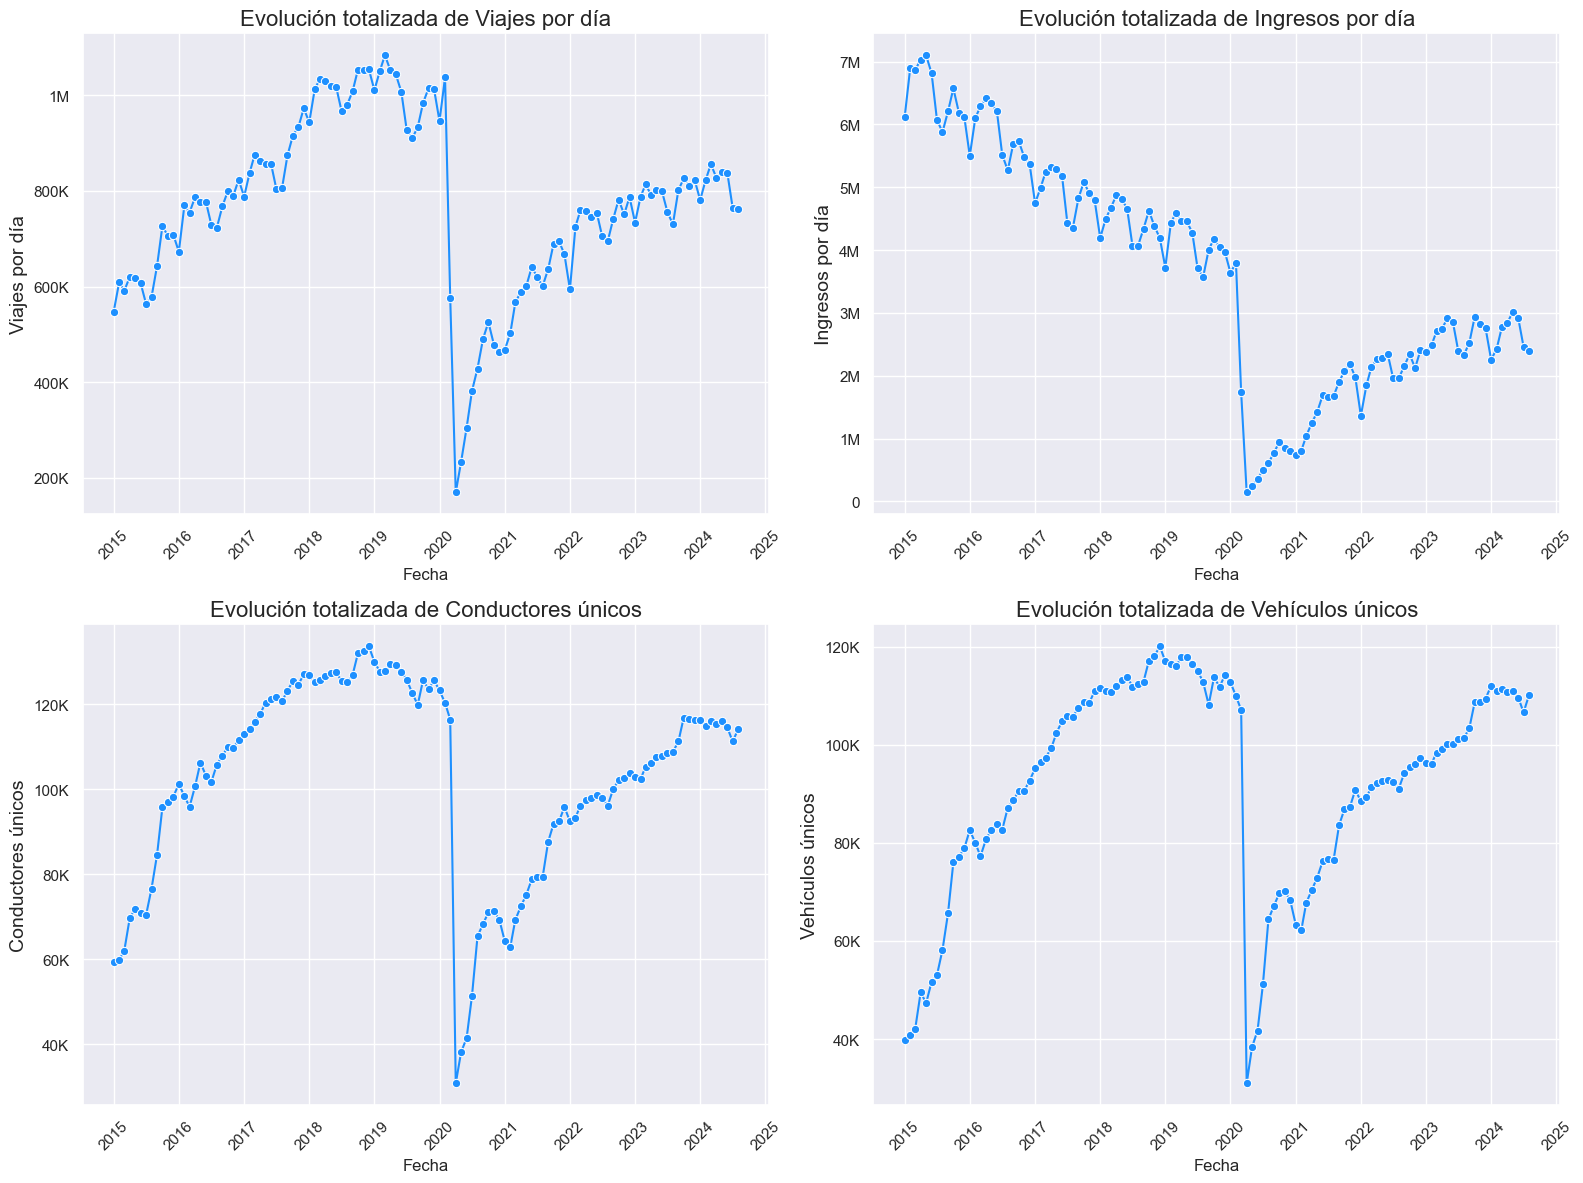

In [ ]:
# Creo un DataFrame totalizado por mes y año y desde 2015
df_totalizado = df.groupby('month_year')[time_columns].sum().reset_index()
df_totalizado = df_totalizado[df_totalizado['month_year'] >= '2015-01-01']

# Diccionario con las unidades de medida correspondientes a cada columna
units = {
    'trips_per_day': 'Viajes por día',
    'farebox_per_day': 'Ingresos por día',
    'unique_drivers': 'Conductores únicos',
    'unique_vehicles': 'Vehículos únicos'
}

def format_axis_y(value, tick_position):
    if value >= 1_000_000:
        return f'{value // 1_000_000:.0f}M'  
    elif value >= 1_000:
        return f'{value // 1_000:.0f}K' 
    else:
        return str(int(value))

plt.figure(figsize=(16, 12))
for i, column in enumerate(time_columns, 1):
    plt.subplot(2, 2, i)
    sns.lineplot(data=df_totalizado, x='month_year', y=column, marker="o", color="dodgerblue")
    plt.title(f"Evolución totalizada de {units[column]}", fontsize=16)
    plt.xlabel('Fecha')
    plt.ylabel(f'{units[column]}', fontsize=14)
    
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_axis_y))   
    plt.xticks(rotation=45)

plt.figtext(0.5, -0.05, "Gráfico 6", wrap=True, horizontalalignment='center', fontsize=9)
plt.tight_layout()
plt.show()